In [61]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
# from google.colab import drive
# drive.mount('/content/drive')

In [63]:
data_path = '/content/drive/MyDrive/080289-main/chap05/data/catanddog/train'

transform = transforms.Compose(
    [
     transforms.Resize([256, 256]),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=8, shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


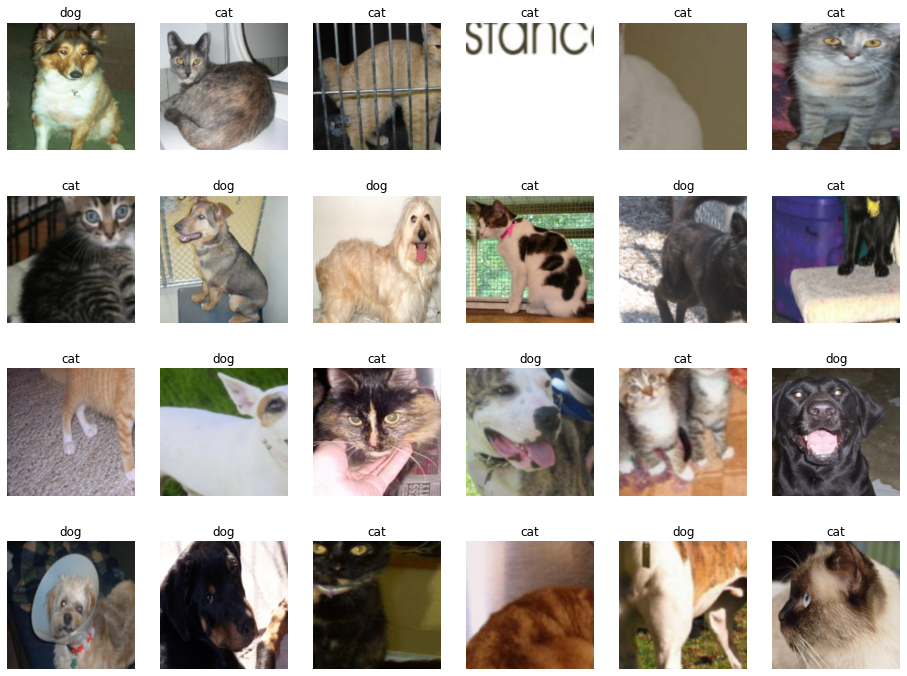

In [64]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16, 24))

for i in range(24):
  a = fig.add_subplot(4, 6, i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [65]:
resnet18 = models.resnet18(pretrained=True)

In [66]:
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [67]:
resnet18.fc = nn.Linear(512, 2)

In [68]:
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0036,  0.0289,  0.0128,  ..., -0.0347,  0.0309,  0.0093],
        [-0.0347,  0.0082,  0.0099,  ...,  0.0252, -0.0111,  0.0229]])
fc.bias tensor([ 0.0116, -0.0030])


In [69]:
model = models.resnet18(pretrained=True)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)

for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=30, is_train=True):
  since = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      
    torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/080289-main/chap05/data/catanddog', f'{epoch}.pth'))
    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed / 60:.0f}m {time_elapsed% 60:.0f}s')
  print(f'Best Acc: {best_acc:4f}')

  return acc_history, loss_history

In [72]:
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print(name)

optimizer = optim.Adam(params_to_update)

fc.weight
fc.bias


In [73]:

criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 0.5464 Acc: 0.7273
Epoch 1/29
----------
Loss: 0.4221 Acc: 0.8104
Epoch 2/29
----------
Loss: 0.3117 Acc: 0.8883
Epoch 3/29
----------
Loss: 0.2832 Acc: 0.8805
Epoch 4/29
----------
Loss: 0.2797 Acc: 0.8805
Epoch 5/29
----------
Loss: 0.2931 Acc: 0.8831
Epoch 6/29
----------
Loss: 0.2408 Acc: 0.8987
Epoch 7/29
----------
Loss: 0.2644 Acc: 0.8883
Epoch 8/29
----------
Loss: 0.2681 Acc: 0.8675
Epoch 9/29
----------
Loss: 0.1818 Acc: 0.9273
Epoch 10/29
----------
Loss: 0.2231 Acc: 0.8987
Epoch 11/29
----------
Loss: 0.2083 Acc: 0.9117
Epoch 12/29
----------
Loss: 0.2160 Acc: 0.9143
Epoch 13/29
----------
Loss: 0.1700 Acc: 0.9273
Epoch 14/29
----------
Loss: 0.1750 Acc: 0.9299
Epoch 15/29
----------
Loss: 0.1945 Acc: 0.9195
Epoch 16/29
----------
Loss: 0.2571 Acc: 0.8805
Epoch 17/29
----------
Loss: 0.1706 Acc: 0.9325
Epoch 18/29
----------
Loss: 0.1747 Acc: 0.9247
Epoch 19/29
----------
Loss: 0.1813 Acc: 0.9195
Epoch 20/29
----------
Loss: 0.1768 Acc: 0.9169
Epoch 21/29
----------
L

In [74]:
test_path = "/content/drive/MyDrive/080289-main/chap05/data/catanddog/test"

transform = transforms.Compose(
    [
     transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 32, num_workers = 1, shuffle = True
)

print(len(test_dataset))

98


In [75]:
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('/content/drive/MyDrive/080289-main/chap05/data/catanddog/' + '*.pth')
  saved_models.sort()
  
  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        outputs = model(inputs)

      _, preds = torch.max(outputs.data, 1)
      preds[preds >= 0.5] = 1
      preds[preds < 0.5] = 0
      running_corrects += preds.eq(labels).int().sum().cpu()

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print(f'Acc: {epoch_acc:.4f}')

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    print()

  time_elapsed = time.time() - since
  print(f'Validation complete in {time_elapsed / 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best Acc: {best_acc:.4f}')

  return acc_history

In [76]:
val_acc_hist = eval_model(resnet18, test_loader, device)

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/0.pth
Acc: 0.8878

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/1.pth
Acc: 0.8980

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/10.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/11.pth
Acc: 0.9184

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/12.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/13.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/14.pth
Acc: 0.9490

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/15.pth
Acc: 0.9490

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/16.pth
Acc: 0.9184

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/17.pth
Acc: 0.9490

Loading model /content/drive/MyDrive/080289-main/chap05/data/catanddog/18.pth
Acc: 0.9184

L

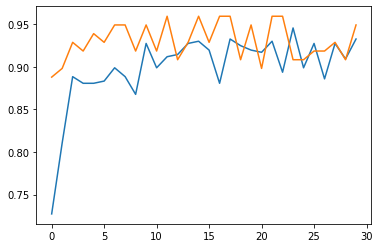

In [77]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

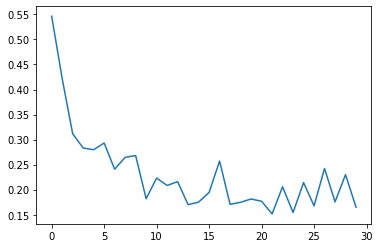

In [78]:
plt.plot(train_loss_hist)
plt.show()

In [79]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1)

  return image

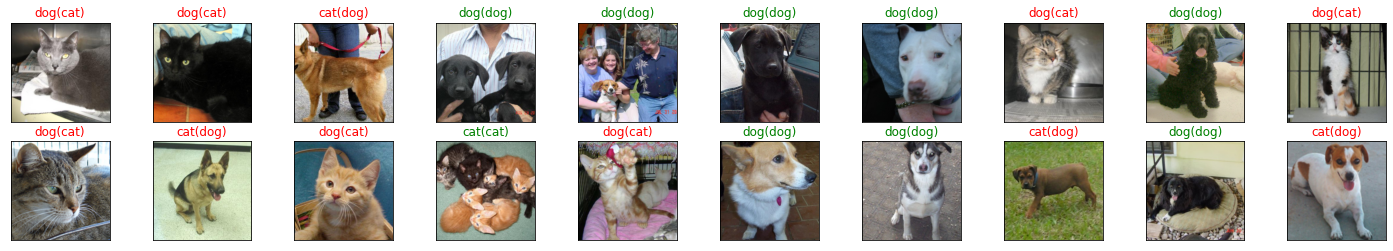

<Figure size 432x288 with 0 Axes>

In [83]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  # ax.set_title(classes[labels[i].item()])
  ax.set_title(f"{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})", color=('green' if preds[idx]==labels[idx] else 'red'))

plt.show()

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)